In [1]:
import torch
import torch.nn as nn
import pandas as pd
import nibabel as nib
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

### Collecting data from given files

In [2]:
def read_eids_from_file(file_path):
    with open(file_path, 'r') as file:
        eids = [line.strip().replace('sub-', '') for line in file.readlines()]
    return eids

def read_mgz_files(base_directory, eids):
    # List to store data
    data_list = []
    # List to store EIDs
    eid_list = []
    # Iterate over EIDs
    for eid in eids:
        # Construct the path to the directory containing .mgz files for each EID
        mgz_file_path = os.path.join(base_directory,f'sub-{eid}','mri','brain.mgz')
        if os.path.exists(mgz_file_path):
            # Read .mgz file using nibabel
            mgz_data = nib.load(mgz_file_path)
            # Extract data array
            data_array = mgz_data.get_fdata().astype('float32')
            # Check if the data can be reshaped to 256x256x256
            if data_array.shape == (256, 256, 256):
                # Append the data and EID to the respective lists
                data_list.append(data_array)
                eid_list.append(eid)
            else:
                print(f"Data shape mismatch for {mgz_file_path}: {data_array.shape}")
        else:
            print(f"File not found: {mgz_file_path}")
    # Create a DataFrame with EID as the reference name
    df = pd.DataFrame({'eid': eid_list, 'Data': data_list})
    return df    

# Path to the file containing EIDs
eid_file_path = 'C:/Users/oybw/Desktop/nick/3DCNN_brain_age/sample_64/pilot_study_64_sub-EID.txt'
# Base directory path where the .mgz files are stored
base_directory_path = 'C:/Users/oybw/Desktop/nick/3DCNN_brain_age/sample_64'
# Path to the CSV file containing age data
age_csv_file_path = os.path.join(base_directory_path, 'pilot_study_64_table.csv')

# Read the EIDs from the file
eids = read_eids_from_file(eid_file_path)

# Read the .mgz files and create a DataFrame
df = read_mgz_files(base_directory_path, eids)
df['eid'] = df['eid'].astype('int32')

# Read the age CSV file into a DataFrame
age_df = pd.read_csv(age_csv_file_path)

# Merge the data DataFrame with the age DataFrame on the EID column
merged_df = pd.merge(df, age_df[['eid', 'age']], on='eid', how='left')

# Display the DataFrame
print(merged_df)


        eid                                               Data  age
0   2769508  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   59
1   2842514  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   49
2   2878974  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   61
3   2890203  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   43
4   2925953  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   57
..      ...                                                ...  ...
63  5884327  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   60
64  5906306  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   44
65  5906306  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   44
66  5906306  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   44
67  5906306  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   44

[68 rows x 3 columns]


### Load saved data for saving time

In [2]:
merged_df = pd.read_pickle("./sample.pkl")

### Create training and evaluating dataset

In [3]:
class BrainDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        data = self.dataframe.iloc[idx]['Data']
        age = self.dataframe.iloc[idx]['age']
        
        # Convert data and age to PyTorch tensors
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        age = torch.tensor(age, dtype=torch.float32)
        
        if self.transform:
            data = self.transform(data)
        
        return data, age

# Define augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    # Add other transforms as needed
])

# Split the DataFrame into training and evaluation sets
train_df, eval_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Create instances of the dataset
train_dataset = BrainDataset(train_df, transform=augmentation_transforms)
eval_dataset = BrainDataset(eval_df)

# Create dataloaders with certain batch_size
# Here I use batch_size = 1 because out of memory for GPU
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=2, shuffle=False)

# Print the first batch to check the data
for data, age in train_loader:
    print("Data batch shape:", data.shape)
    print("Age batch:", age)
    break


Data batch shape: torch.Size([2, 1, 256, 256, 256])
Age batch: tensor([44., 61.])


### Build 3DCNN model

In [4]:
class CNN3D(nn.Module):
    def __init__(self, width=256, height=256, depth=256):
        super(CNN3D, self).__init__()

        # Define layers similar to the TensorFlow model
        self.conv1 = nn.Conv3d(1, 16, kernel_size=6, stride=1, padding=0)
        self.pool1 = nn.MaxPool3d(kernel_size=2)
        self.bn1 = nn.BatchNorm3d(16)

        self.conv2 = nn.Conv3d(16, 32, kernel_size=6, stride=1, padding=0)
        self.pool2 = nn.MaxPool3d(kernel_size=2)
        self.bn2 = nn.BatchNorm3d(32)
        self.dropout1 = nn.Dropout3d(p=0.2)

        self.conv3 = nn.Conv3d(32, 64, kernel_size=6, stride=1, padding=0)
        self.pool3 = nn.MaxPool3d(kernel_size=2)
        self.bn3 = nn.BatchNorm3d(64)
        self.dropout2 = nn.Dropout3d(p=0.2)

        self.conv4 = nn.Conv3d(64, 128, kernel_size=6, stride=1, padding=0)
        self.pool4 = nn.MaxPool3d(kernel_size=2)
        self.bn4 = nn.BatchNorm3d(128)
        self.dropout3 = nn.Dropout3d(p=0.2)

        self.global_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(128, 128)
        self.dropout4 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional layers with activations and pooling
        x = self.pool1(self.bn1(nn.functional.relu(self.conv1(x))))
        x = self.dropout1(self.pool2(self.bn2(nn.functional.relu(self.conv2(x)))))
        x = self.dropout2(self.pool3(self.bn3(nn.functional.relu(self.conv3(x)))))
        x = self.dropout3(self.pool4(self.bn4(nn.functional.relu(self.conv4(x)))))

        # Global average pooling and fully connected layers
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Create model
model = CNN3D()

# Print the model architecture
print(model)


CNN3D(
  (conv1): Conv3d(1, 16, kernel_size=(6, 6, 6), stride=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(16, 32, kernel_size=(6, 6, 6), stride=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout3d(p=0.2, inplace=False)
  (conv3): Conv3d(32, 64, kernel_size=(6, 6, 6), stride=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout3d(p=0.2, inplace=False)
  (conv4): Conv3d(64, 128, kernel_size=(6, 6, 6), stride=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm3d(1

### Model training

In [5]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Example scheduler

# Training loop
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #'cpu'
model.to(device)

# Record train loss, evaluate loss, outputs age and true age
train_losses = []
eval_losses = []
all_outputs = []
all_ages = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    min_epoch_loss = float('inf')

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for data, age in train_loader_tqdm:
        # Move tensors to the appropriate device (GPU or CPU)
        data, age = data.to(device), age.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs.squeeze(), age)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        train_loader_tqdm.set_postfix({"Loss": loss.item()})

    epoch_loss = running_loss / len(train_dataset)
    if epoch_loss < min_epoch_loss:
        # Save the model state dictionary
        torch.save(model.state_dict(), 'model_best.pth')
        min_epoch_loss = epoch_loss
    print(f"Epoch {epoch+1}/{num_epochs}, Epoch Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for data, age in eval_loader:
            data, age = data.to(device), age.to(device)
            outputs = model(data)
            loss = criterion(outputs.squeeze(), age)
            eval_loss += loss.item()

    # Calculate average validation loss
    avg_eval_loss = eval_loss / len(eval_loader)

    scheduler.step(avg_eval_loss)  # Update the learning rate

print("Training complete")


Epoch 1/100:   0%|          | 0/27 [00:00<?, ?batch/s]c:\Users\oybw\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv3d(
Epoch 1/100: 100%|██████████| 27/27 [22:48<00:00, 50.69s/batch, Loss=14.2] 


Epoch 1/100, Epoch Loss: 29.4805


Epoch 2/100:  41%|████      | 11/27 [02:16<02:27,  9.23s/batch, Loss=19.7]

### Model evaluation

In [11]:
# Evaluation phase
model = CNN3D().to(device)
# Load the model state dictionary
model.load_state_dict(torch.load('model_best.pth'))

model.eval()
eval_loss = 0.0
epoch_outputs = []
epoch_ages = []
with torch.no_grad():
    for data, age in eval_loader:
        data, age = data.to(device), age.to(device)
        outputs = model(data)
        loss = criterion(outputs.squeeze(), age)
        eval_loss += loss.item() * data.size(0)

        epoch_outputs.extend(outputs.cpu().numpy())
        epoch_ages.extend(age.cpu().numpy())
    
eval_loss = eval_loss / len(eval_dataset)
eval_losses.append(eval_loss)
all_outputs.extend(epoch_outputs)
all_ages.extend(epoch_ages)
print(f"Evaluation Loss: {eval_loss:.4f}")

Evaluation Loss: 7.3905


### Plot for train loss vs evaluation loss

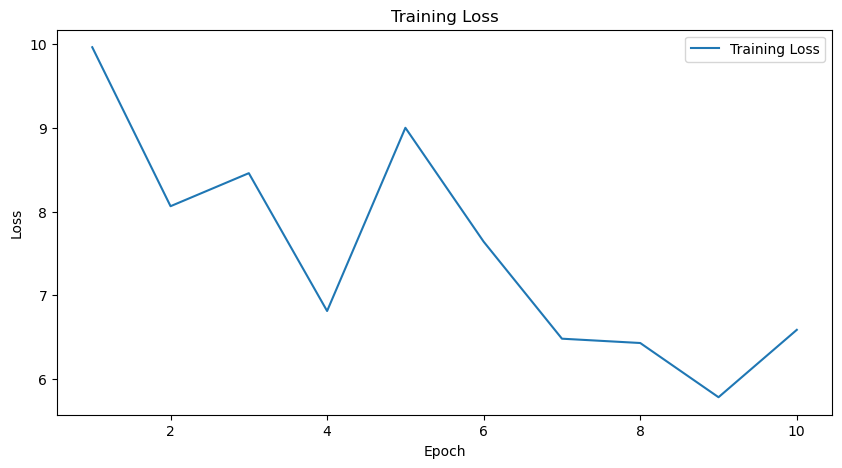

<Figure size 1000x500 with 0 Axes>

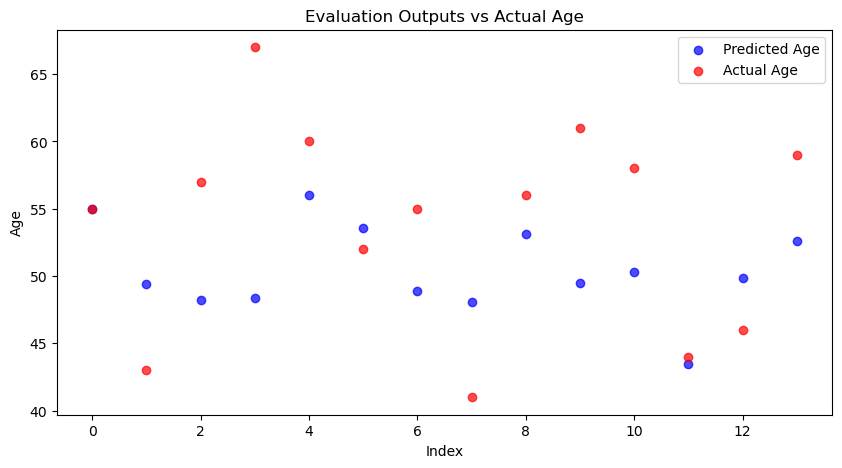

In [8]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot the evaluation outputs vs actual age
plt.figure(figsize=(10, 5))
plt.figure(figsize=(10, 5))
plt.scatter(range(len(all_outputs)), all_outputs, color='blue', alpha=0.7, label='Predicted Age')
plt.scatter(range(len(all_ages)), all_ages, color='red', alpha=0.7, label='Actual Age')
plt.xlabel('Index')
plt.ylabel('Age')
plt.title('Evaluation Outputs vs Actual Age')
plt.legend()
plt.show()

In [11]:
print(all_ages)

[55.0, 43.0, 57.0, 67.0, 60.0, 52.0, 55.0, 41.0, 56.0, 61.0, 58.0, 44.0, 46.0, 59.0]
